# Plotting snow thickness trends

This notebook describes how to plot snow thickness trends for the algal bloom paper.  

I use monthly mean snow thicknesses estimated using ERA5 inputs.  These were downloaded from https://nsidc.org/data/nsidc-0758/versions/1.

The original files do not play nicely with `xarray`.  So I calculated monthly mean snow thickness separately.

The notebook calculates trend slopes using `scipy.stats.linregress`.  Trends slopes are explored, along with mean snow depth and the impact of trend on snow depths. 

In [14]:
from pathlib import Path
import calendar

import xarray as xr
import scipy.stats as sstats
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, ListedColormap

import cartopy.crs as ccrs
import cartopy.feature as cfeature

try:
    from nsidc_projections.grid import EASEGridNorth25km
except:
    print("nsidc_projections is not installed\n\n"
          "To install:\n   git clone https://github.com/andypbarrett/nsidc_projections\n"
          "   mamba env update\n"
          "or\n"
          "   conda env update\n")

# Change filepath to the path of mean snow thickness on your local machine
DATAPATH = Path("/home/apbarret/Data/Sunlight_under_seaice/SnowModelData/original/month/sm_snod_era5_19800801to20210731.month.nc")

## Load data

I start with monthly mean snow depths that are calculated from daily snow depth data

In [2]:
ds = xr.open_dataset(DATAPATH, chunks={"time": 1})
ds

<xarray.Dataset>
Dimensions:                       (x: 361, y: 361, time: 492)
Coordinates:
    lambert_azimuthal_equal_area  int32 ...
  * x                             (x) float32 -4.5e+06 -4.475e+06 ... 4.5e+06
  * y                             (y) float32 -4.5e+06 -4.475e+06 ... 4.5e+06
  * time                          (time) datetime64[ns] 1980-08-31 ... 2021-0...
Data variables:
    snod                          (time, y, x) float32 dask.array<chunksize=(1, 361, 361), meta=np.ndarray>
Attributes: (12/13)
    CDI:           Climate Data Interface version 1.9.1 (http://mpimet.mpg.de...
    Conventions:   CF-1.6
    history:       Sat Apr 24 07:50:34 2021: cdo -f nc import_binary SM_snod_...
    CDO:           Climate Data Operators version 1.9.1 (http://mpimet.mpg.de...
    title:         snow depth and density on sea ice
    institution:   CIRA, Colorado State University
    ...            ...
    source:        SnowModel-LG
    projection:    NSIDC EASE
    proj4_string:  NSIDC_EASE_North.proj4_init
    proj_string:   +proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +a=6371228 +b=...
    crs:           EPSG:3408
    reference:     Liston, G. E., Itkin, P., Stroeve, J., Tschudi, M., Stewar...

## Calculating the trend line

I use [`scipy.stats.linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) to calculate a trend line.  I only use the trend `slope`, `intercept` and `pvalue`.  `pvalue` is the p-value for a hypothesis test with the null value that the slope is zero.  See the documentation for more information.

The code below applies this to a single grid cell.

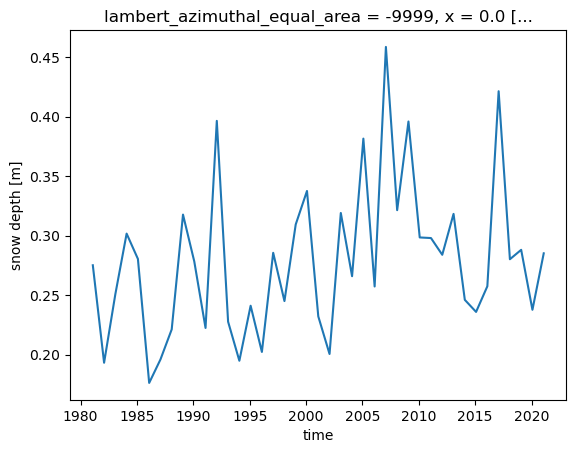

In [161]:
month = 1
xx = 0
yy = 0
da = ds.sel(time=(ds.time.dt.month == month), x=xx, y=yy).snod
da.plot()

I only want some of the statistics returned by `linregress` so I define a wrapper function.  This is used in `calculate_trend` below.

In [162]:
def my_linregress(x, y):
    """Wrapper to return regression slope, intercept and p-value"""
    lm = sstats.linregress(x, y)
    return lm.slope, lm.intercept, lm.pvalue

We'll plot the time series and the trend line.  I also add text to give the slope and p-value.  The level of significance of the p-value is indicated by `*` for $\alpha = 0.1$, `**` for $\alpha = 0.05$, and `***` for $\alpha = 0.01$.

Text(0.5, 1.0, 'January x=0.0 y=0.0')

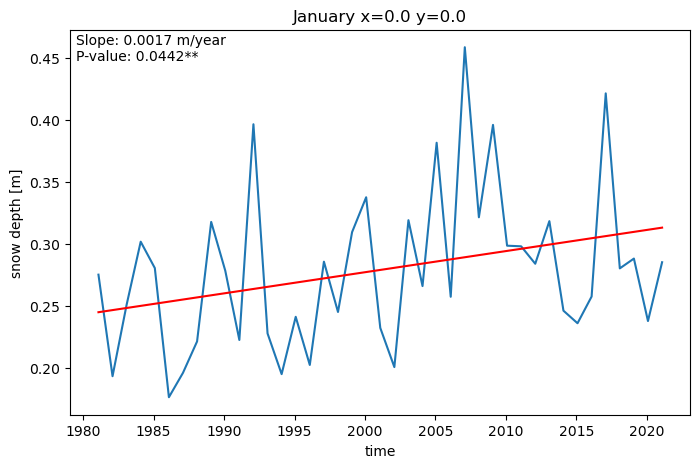

In [165]:
slope, intercept, pvalue = my_linregress(da.time.dt.year, da.values)

fig, ax = plt.subplots(figsize=(8,5))

da.plot(ax=ax)

x = da.time
y = da.time.dt.year *slope + intercept

ax.plot(x, y, c='red')
ax.text(0.01, 0.99, f"Slope: {slope:.4f} m/year\nP-value: {pvalue:.4f}{''.join(['*' for a in [0.1, 0.05, 0.01] if pvalue <= a])}", 
        transform=ax.transAxes, va="top")
ax.set_title(f"{calendar.month_name[month]} x={xx:.1f} y={yy:.1f}")

## Find grid cells with snow depth

For each grid cell plot the number of months, grouped by month, that have snow depth greater than zero.  This is used to mask out grid cells with insufficient data to calculate a trend.  This would be accounted for in statistical significance but I want to be able to show grid cells that have no trend.

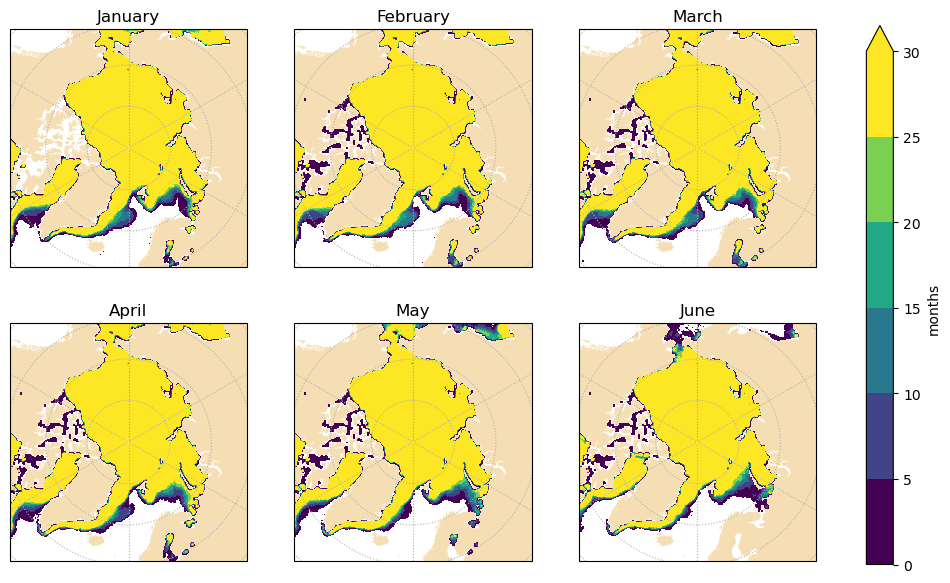

In [151]:
issnow = ds.snod.where(ds.snod > 0) > 0
nsnow = issnow.groupby(issnow.time.dt.month).sum(skipna=False)
nsnow = nsnow.where(nsnow > 0)

minimum_snow_month = 20
norm = BoundaryNorm(np.arange(0, 32, 5), 256)

fig = plt.figure(figsize=(13,7))

axes = []
for month in np.arange(1,7):
    
    ax = fig.add_subplot(2, 3, month, projection=proj)
    ax.set_extent(extent, proj)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, facecolor="wheat")
        
    img = nsnow.sel(month=month).plot.imshow(interpolation='none', 
                                             add_colorbar=False,
                                             norm=norm)
    # img = sig_slope.sel(month=month).plot.imshow(vmin=vmin, vmax=vmax,
    #                                              interpolation="none", 
                                                 
    #                                              cmap="coolwarm")
    ax.set_title(calendar.month_name[month])
    ax.set_aspect(1)

    ax.gridlines(linestyle='dotted')
    
fig.colorbar(img, ax=fig.axes, label="months", extend="max")



## Make trend maps

`linregress` expects 1-D inputs.  The function needs to be applied to each grid cell.  I use the `xarray.apply_ufunc` method to vectorize the trend calculation to all grid cells.  The results are written to an xarray.Dataset that can be written to a file.

In [166]:
%%time

def calculate_trend(da):
    slope, intercept, pvalue = xr.apply_ufunc(my_linregress, 
                                              da.time.dt.year, da, 
                                              dask="forbidden", 
                                              input_core_dims=[["time"], ["time"]],
                                              output_core_dims=[[], [], []],
                                              vectorize=True,
                                              keep_attrs=True,
                                             )
    slope.attrs = {
        "long_name": "trend of monthly mean snow depth",
        "units": "m/year",
        "standard_name": "tendency_of_surface_snow_thickness",
    }
    intercept.attrs = {
        "long_name": "intercept of trend of monthly mean snow depth",
        "units": "m",
    }
    pvalue.attrs = {
        "long_name": "P-value for trend of monthly mean snow depth",
        "units": "None",
    }
    ds_trend = xr.Dataset({"slope": slope, "intercept": intercept, "pvalue": pvalue})
    ds_trend = ds_trend.expand_dims({"month": 1}, axis=0)
    return ds_trend

ds_trend = xr.concat([calculate_trend(ds.snod.sel(time=(ds.time.dt.month == m)).load()) for m in np.arange(1,13)], dim="month")

CPU times: user 57 s, sys: 107 ms, total: 57.1 s
Wall time: 57.1 s


In [7]:
ds_trend

<xarray.Dataset>
Dimensions:                       (x: 361, y: 361, month: 12)
Coordinates:
    lambert_azimuthal_equal_area  int32 -9999
  * x                             (x) float32 -4.5e+06 -4.475e+06 ... 4.5e+06
  * y                             (y) float32 -4.5e+06 -4.475e+06 ... 4.5e+06
Dimensions without coordinates: month
Data variables:
    slope                         (month, y, x) float64 nan nan nan ... nan nan
    intercept                     (month, y, x) float64 nan nan nan ... nan nan
    pvalue                        (month, y, x) float64 nan nan nan ... nan nan

## Plot only significant trends

Strictly speaking, for a hypothesis test for trend with a null hypothesis that trend is zero (i.e. no trend), only trend slopes that have a P-value less than or equal to the chosen level of significance can be said to indicate a trend.  Trend slopes with P-values greater than the chosen level of significance have a trend of zero or no trend.  Following this interpretation of the hypothesis test, I set trend slopes with P-values greater than the significance level (in this case $\alpha = 0.05$) to zero.  I also mask cells that have less than 20 years of data for the month of interest.  This allows the extent of the dataset to be shown even when there is no trend.

Trends are converted from m/year to cm/decade to scale the results.  Note that a trend of 4 cm/decade is very small and unlikely to have much of an impact on light transmission.

/home/apbarret/mambaforge/envs/algal-bloom-paper/lib/python3.12/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


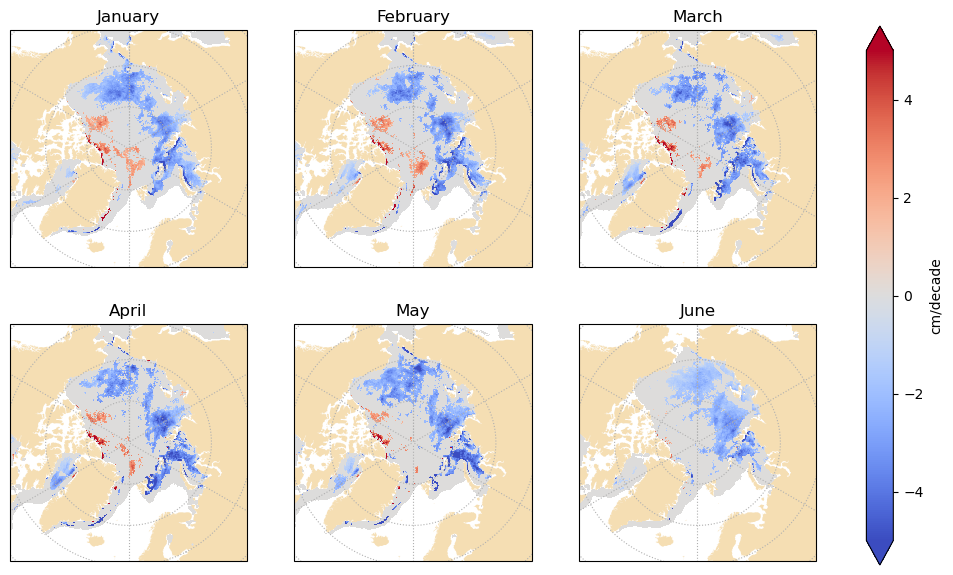

In [167]:
proj = EASEGridNorth25km.to_cartopy()  # From nsidc_projections 
scale = 0.35
extent = list(chain(*[(min(x)*scale, max(x)*scale) for x in list(zip(*EASEGridNorth25km.grid_bounds()))]))

# Scale slope to cm/decade
m2cm = 100.
year2decade = 0.1
slope = ds_trend.slope * m2cm / year2decade

# Set slopes that do not have high significance to zero
alpha = 0.05  # Level of significance
sig_slope = slope.where((ds_trend.pvalue <= alpha), 0.)  # cells where the condition is False are set to zero

# Set cells with number of snow covered months less than or equal to 20
# to missing (NaN)
minimum_years = 20
sig_slope = sig_slope.where(nsnow > minimum_years)

vmin = -0.005 * m2cm / year2decade
vmax = 0.005 * m2cm / year2decade

fig = plt.figure(figsize=(13,7))

axes = []
for month in [1, 2, 3, 4, 5, 6]:
    
    ax = fig.add_subplot(2, 3, month, projection=proj)
    ax.set_extent(extent, proj)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, facecolor="wheat")
        
    img = sig_slope.sel(month=month).plot.imshow(vmin=vmin, vmax=vmax,
                                                 interpolation="none", 
                                                 add_colorbar=False,
                                                 cmap="coolwarm")
    ax.set_title(calendar.month_name[month])
    ax.set_aspect(1)

    ax.gridlines(linestyle='dotted')
    
fig.colorbar(img, ax=fig.axes, label="cm/decade", extend="both")

fig.savefig("figure02.snow_thickness_trend.png")

## Plotting Significance Levels

I've used $\alpha = 0.05$ because this is what is used in the paper.  However, just out of interest, I plot the P-value of trend slopes binned by level of significance to see how this looks.  The differences between levels of significance are small and don't really change the results.  Significant trends are multiplied by the sign of the slope to indicate if the slope if significant positive or negative.  Note: a two-tailed test is still applied.

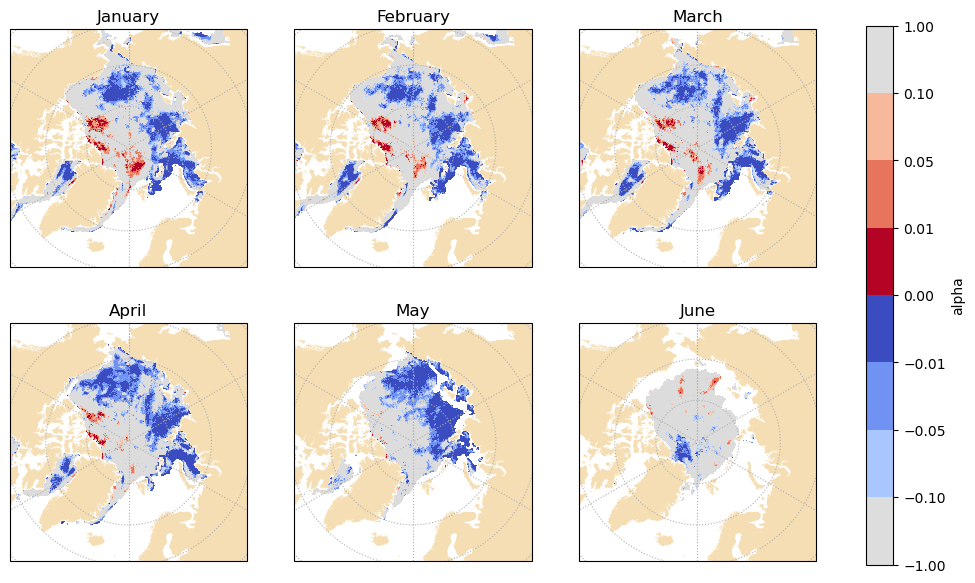

In [174]:
fig = plt.figure(figsize=(13,7))

trend = np.where(ds_trend.slope < 0, -1, 1)

trend_sig = ds_trend.pvalue * trend

vmin = -1.
vmax = 1.

# Make a new colormap for sig levels
cmap = mpl.colormaps['coolwarm'].resampled(7)
new_cmap = ListedColormap([cmap(i) for i in [3,2,1,0,6,5,4,3]])
# Make Norm
norm = BoundaryNorm([-1,-0.1,-0.05,-0.01,0.,0.01,0.05,0.1,1], new_cmap.N)

axes = []
for month in [1, 2, 3, 4, 5, 6]:
    
    ax = fig.add_subplot(2, 3, month, projection=proj)
    ax.set_extent(extent, proj)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, facecolor="wheat")
        
    img = trend_sig.sel(month=month).plot.imshow(vmin=vmin, vmax=vmax,
                                                 interpolation="none", 
                                                 add_colorbar=False,
                                                 cmap=new_cmap,
                                                 norm=norm,
                                                )
    ax.set_title(calendar.month_name[month])
    ax.set_aspect(1)

    ax.gridlines(linestyle='dotted')
    
fig.colorbar(img, ax=fig.axes, label="alpha", extend="neither")

fig.savefig("snow_thickness_trend_significance.png")

## Plot mean monthly snow depth

The impact of the trend on light transmission will depend on snow depth.  Even this snow depths can stop light from pentrating to the ocean.  So it is useful to know what the mean snow depth looks like.  Here, I calculate the snow depth climatology by month using monthly mean snow depths.

_A more thorough analysis could involve looking at climatologies calculated from the daily snow depths._

In [77]:
dsclim = ds.snod.groupby(ds.time.dt.month).mean(dim="time", keep_attrs=True)
dsclim = dsclim * 100.
dsclim.attrs["units"] = "cm"
dsclim

<xarray.DataArray 'snod' (month: 12, y: 361, x: 361)>
dask.array<mul, shape=(12, 361, 361), dtype=float32, chunksize=(1, 361, 361), chunktype=numpy.ndarray>
Coordinates:
    lambert_azimuthal_equal_area  int32 ...
  * x                             (x) float32 -4.5e+06 -4.475e+06 ... 4.5e+06
  * y                             (y) float32 -4.5e+06 -4.475e+06 ... 4.5e+06
  * month                         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:    cm

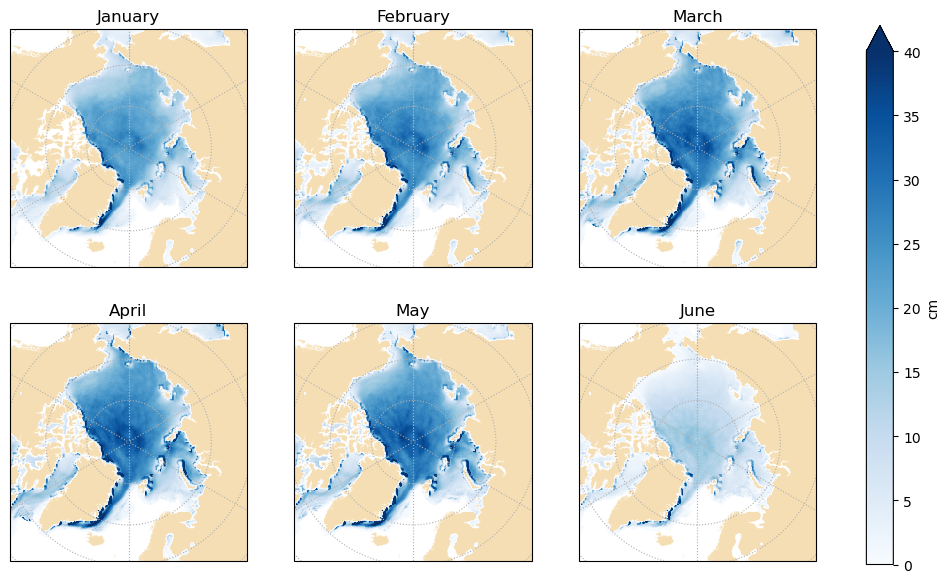

In [175]:
fig = plt.figure(figsize=(13,7))

vmin = 0
vmax = 40.

axes = []
for month in [1, 2, 3, 4, 5, 6]:
    
    ax = fig.add_subplot(2, 3, month, projection=proj)
    ax.set_extent(extent, proj)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, facecolor="wheat")
        
    img = dsclim.sel(month=month).plot.imshow(vmin=vmin, vmax=vmax,
                                                 interpolation="none", 
                                                 add_colorbar=False,
                                                 cmap="Blues")
    ax.set_title(calendar.month_name[month])
    ax.set_aspect(1)

    ax.gridlines(linestyle='dotted')
    
fig.colorbar(img, ax=fig.axes, label="cm", extend="max")


## Plot trend as a percentage of mean

The better way to think about this might be to show cells that will drop below a threshold where sunlight is not extinguished by snow.

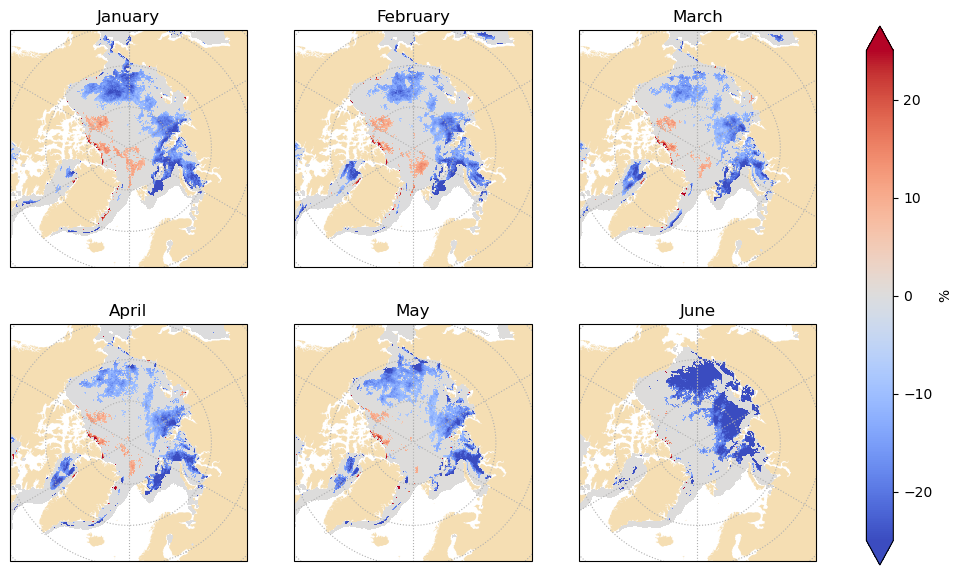

In [93]:
trend_pc = sig_slope * 100. / dsclim

fig = plt.figure(figsize=(13,7))

vmin = -25.
vmax = 25.

axes = []
for month in [1, 2, 3, 4, 5, 6]:
    
    ax = fig.add_subplot(2, 3, month, projection=proj)
    ax.set_extent(extent, proj)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, facecolor="wheat")
        
    img = trend_pc.sel(month=month).plot.imshow(vmin=vmin, vmax=vmax,
                                                 interpolation="none", 
                                                 add_colorbar=False,
                                                 cmap="coolwarm")
    ax.set_title(calendar.month_name[month])
    ax.set_aspect(1)

    ax.gridlines(linestyle='dotted')
    
fig.colorbar(img, ax=fig.axes, label="%", extend="both")

fig.savefig("snow_depth_trend_as_percent_climatology.png")

## Use hatching to distinguish significant trends

An alternative way of displaying trends are to show all the trends and stipple the regions with significant trends.  This is done by adding a filled contour layer that uses `pvalue`.  Only three levels are required `[0., $\alpha$, 1.]`.  The hatch or stipple pattern is set in the call to `contourf` and `colors` is set to `none` so that only the stipple pattern is plotted.  The density of stippling is set by repeating the stipple pattern type.  For example; `'.'`, or `'..'`, or `'...'`.  The call to `contourf` looks like;

```
alpha = 0.05  # Level of significance
levels = [0., alpha, 1.]
hatches = ['..', None]

cnt = sig.sel(month=month).plot.contourf(levels=levels,
                                         hatches=hatches,
                                         colors='none',
                                         add_colorbar=False)
```

where `sig` is the p-value `DataArray`.

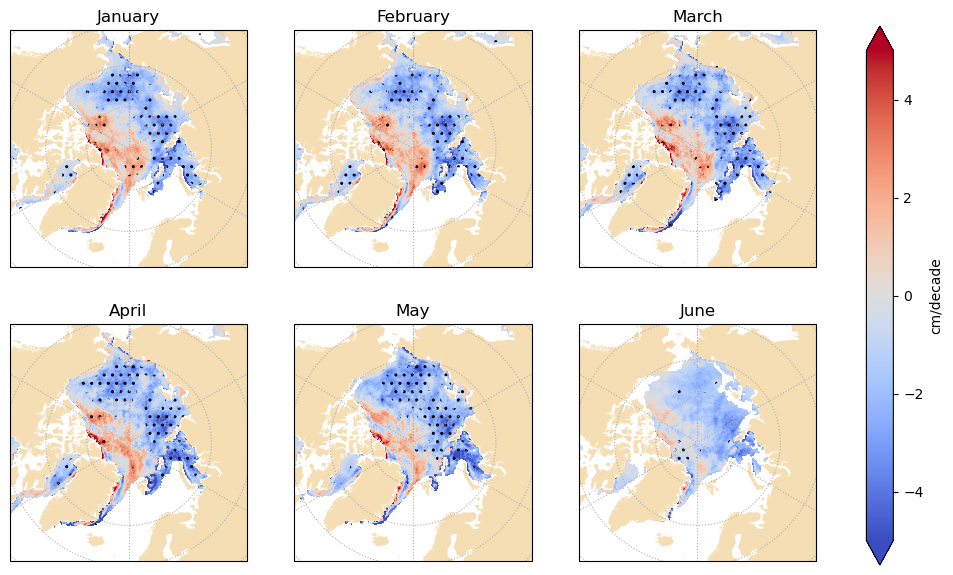

In [176]:
# Scale slope to cm/decade
m2cm = 100.
year2decade = 0.1
slope = ds_trend.slope * m2cm / year2decade
sig = ds_trend.pvalue

# Set slopes that do not have high significance to zero
alpha = 0.05  # Level of significance
levels = [0., alpha, 1.]
hatches = ['..', None]
    
# Set cells with number of snow covered months less than or equal to 20
# to missing (NaN)
minimum_years = 20
slope = slope.where(nsnow > minimum_years)

vmin = -0.005 * m2cm / year2decade
vmax = 0.005 * m2cm / year2decade

fig = plt.figure(figsize=(13,7))

axes = []
for month in [1, 2, 3, 4, 5, 6]:
    
    ax = fig.add_subplot(2, 3, month, projection=proj)
    ax.set_extent(extent, proj)
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, facecolor="wheat")
        
    img = slope.sel(month=month).plot.imshow(vmin=vmin, vmax=vmax,
                                             interpolation="none", 
                                             add_colorbar=False,
                                             cmap="coolwarm")
    cnt = sig.sel(month=month).plot.contourf(levels=levels,
                                             hatches=hatches,
                                             colors='none',
                                             add_colorbar=False)
        
    ax.set_title(calendar.month_name[month])
    ax.set_aspect(1)

    ax.gridlines(linestyle='dotted')
    
fig.colorbar(img, ax=fig.axes, label="cm/decade", extend="both")

fig.savefig("figure02.snow_thickness_trend.hatching.png")